In [13]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [14]:
df_train_dir = "C:\\Users\\rianf\\OneDrive\\Documentos\\projetosML\\ProjetoClassificacaoImagemCNNRaioX\\Data\\chest_xray\\train"
df_test_dir = "C:\\Users\\rianf\\OneDrive\\Documentos\\projetosML\\ProjetoClassificacaoImagemCNNRaioX\\Data\\chest_xray\\test"


In [37]:
df_train = keras.utils.image_dataset_from_directory(
    df_train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary"
)


df_val = keras.utils.image_dataset_from_directory(
    df_train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    batch_size=32,
    label_mode="binary"
)

df_test = keras.utils.image_dataset_from_directory(
    df_test_dir,
    image_size = (150, 150),
    batch_size= 32,
    label_mode= "binary",
    shuffle = True,
)

Found 7315 files belonging to 2 classes.
Using 5852 files for training.
Found 7315 files belonging to 2 classes.
Using 1463 files for validation.
Found 620 files belonging to 2 classes.


In [16]:
df_train.class_names

['NORMAL', 'PNEUMONIA']

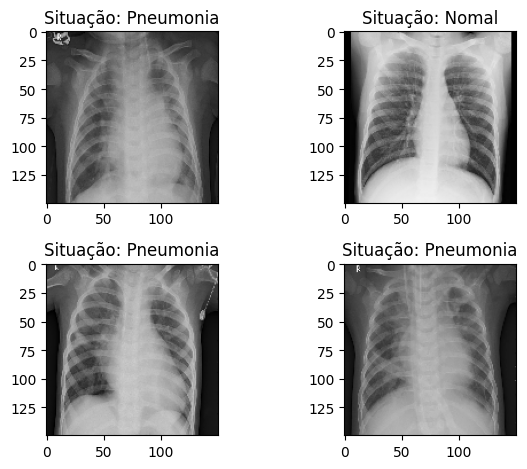

In [17]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()

for imagem, label in df_train.take(1):
    for i in range(4):
        axs[i].imshow(imagem[i].numpy().astype("uint8"))
        axs[i].set_title(f"Situação: {'Nomal' if label[i].numpy()==0 else 'Pneumonia'}")

plt.tight_layout()
plt.show()

In [18]:
def redimensionarImagem(imagem, label):
    imagem = imagem / 255
    return imagem, label 

In [19]:
df_train = df_train.map(redimensionarImagem)
df_test = df_test.map(redimensionarImagem)


In [20]:
for imagem, label in df_train.take(1):
    print(imagem)

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.05798693 0.05798693 0.05798693]
   [0.10611068 0.10611068 0.10611068]
   ...
   [0.04659849 0.04659849 0.04659849]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.0445851  0.0445851  0.0445851 ]
   [0.10618299 0.10618299 0.10618299]
   ...
   [0.03430846 0.03430846 0.03430846]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.03474902 0.03474902 0.03474902]
   [0.11079957 0.11079957 0.11079957]
   ...
   [0.00169941 0.00169941 0.00169941]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

In [47]:
modelo = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

from tensorflow.keras.metrics import Precision, Recall

# Adicione estas métricas ao compilar o modelo
modelo.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

history = modelo.fit(df_train, validation_data=df_val, epochs=5, batch_size=32)

Epoch 1/5


c:\Users\rianf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.6484 - loss: 2.5726 - precision: 0.6704 - recall: 0.6520 - val_accuracy: 0.8913 - val_loss: 0.2502 - val_precision: 0.8542 - val_recall: 0.9572
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 49s 264ms/step - accuracy: 0.9141 - loss: 0.2204 - precision: 0.9221 - recall: 0.9131 - val_accuracy: 0.9234 - val_loss: 0.2048 - val_precision: 0.9073 - val_recall: 0.9520
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 48s 264ms/step - accuracy: 0.9336 - loss: 0.1702 - precision: 0.9400 - recall: 0.9330 - val_accuracy: 0.9440 - val_loss: 0.1549 - val_precision: 0.9503 - val_recall: 0.9429
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 48s 264ms/step - accuracy: 0.9407 - loss: 0.1533 - precision: 0.9452 - recall: 0.9419 - val_accuracy: 0.9508 - val_loss: 0.1492 - val_precision: 0.9755 - val_recall: 0.9300
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 50s 274ms/step - accuracy: 0.9509 - loss: 0.1370 - precision: 0.9560 - recall: 0.9503 - val_accuracy: 0.9433 - val_loss: 0.

In [48]:
modelo.evaluate(df_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9389 - loss: 0.1818 - precision: 0.9369 - recall: 0.9688


[0.18891480565071106,
 0.9274193644523621,
 0.9148418307304382,
 0.9740932583808899]

In [50]:
history.history

{'accuracy': [0.7653793692588806,
  0.9176350235939026,
  0.9314764142036438,
  0.9415584206581116,
  0.9494190216064453],
 'loss': [0.9320672750473022,
  0.20832844078540802,
  0.1723019927740097,
  0.15519733726978302,
  0.13361971080303192],
 'precision': [0.7885828018188477,
  0.9263942837715149,
  0.9390994310379028,
  0.9456241726875305,
  0.9527330994606018],
 'recall': [0.7634961605072021,
  0.9180591106414795,
  0.9315552711486816,
  0.9444087147712708,
  0.952120840549469],
 'val_accuracy': [0.891319215297699,
  0.9234449863433838,
  0.9439507722854614,
  0.9507860541343689,
  0.943267285823822],
 'val_loss': [0.25023195147514343,
  0.2048119157552719,
  0.1549265831708908,
  0.14924897253513336,
  0.14428876340389252],
 'val_precision': [0.8541666865348816,
  0.9072929620742798,
  0.9503268003463745,
  0.9755101799964905,
  0.9410256147384644],
 'val_recall': [0.957198441028595,
  0.9520103931427002,
  0.9429312348365784,
  0.929961085319519,
  0.9520103931427002]}

C:\Users\rianf\AppData\Local\Temp\ipykernel_15592\733793871.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


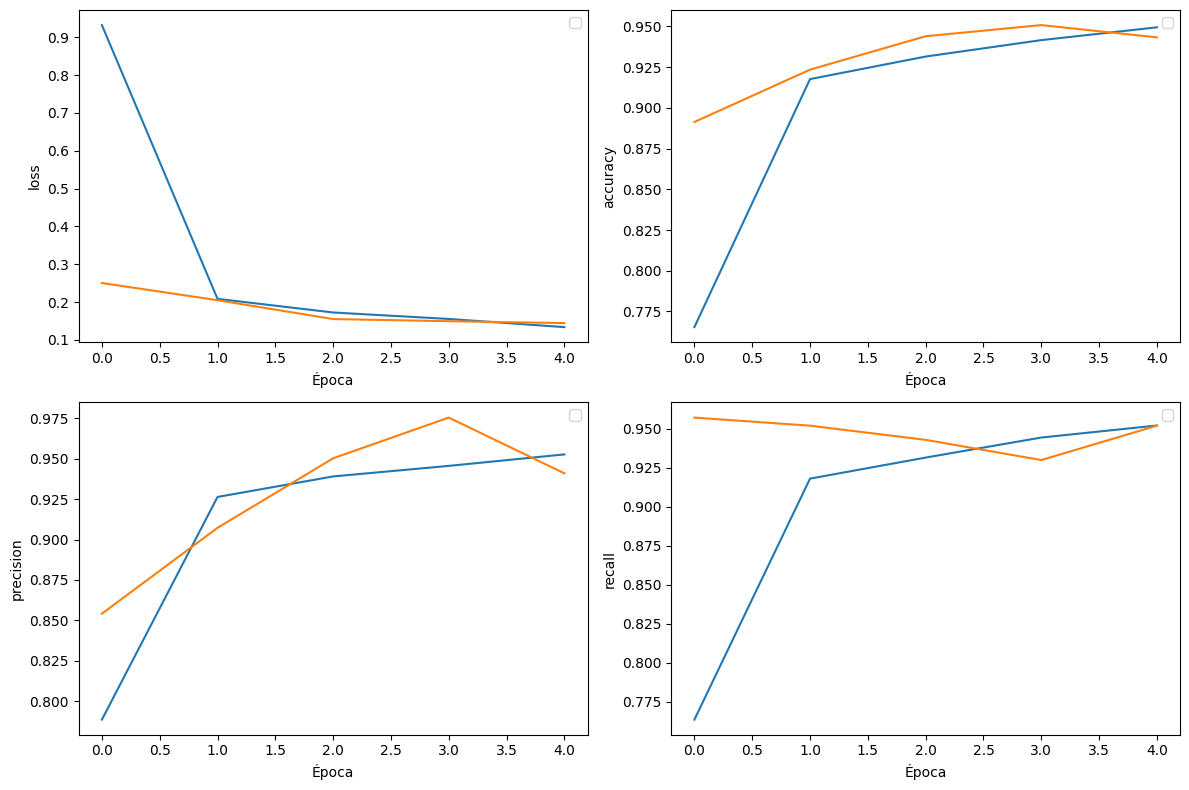

In [71]:
import matplotlib.pyplot as plt



fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
metrics = ['loss', 'accuracy', 'precision', 'recall']
for i, metric in enumerate(metrics):
    axs[i].plot(history.history[metric])
    axs[i].plot(history.history[f"val_{metric}"])
    axs[i].set_xlabel('Época')
    axs[i].set_ylabel(metric)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [72]:
modelo.save('App/Model/modelo_completo.h5')